# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL. 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### TODO LIST FOR THE GROUP:

<input type="checkbox" checked > New architecture of file

<input type="checkbox" checked > Create functions to import and convert initial files

<input type="checkbox" checked > More comments on the dataset -> distribution, viz

<input type="checkbox" checked > For any filtering: how, why ?

<input type="checkbox"> Choose a NLP method -> comment as much as possible, some trials 

<input type="checkbox" checked > E-mail the proposition to Beatriz

## Datasets 📂
### Import dataset and libraries 📥

In [1]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from langdetect import detect
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog, smog_index, automated_readability_index, coleman_liau_index, linsear_write_formula, dale_chall_readability_score, text_standard
from utils import *
pd.set_option('display.max_columns', None)

In [2]:
dataset_path = './data/BeerAdvocate/'

In [4]:
# Firt time imports : 
# Convert txt to csv (function in the utils.py file)

#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

In [5]:
# Files already converted, so we can load them directly

reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### Initial datasets analysis 🔎

#### Beers dataset 🍺

In [6]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
191708,125363,First Run,31723,Lookout Brewing Co.,American Amber / Red Ale,3,0,3.81,NaN,NaN,4.0,3.810,NaN,0,NaN
162086,248678,Golden Maris Summer Ale,40740,St. Joseph Brewery & Public House,American Pale Ale (APA),2,0,3.13,NaN,NaN,5.2,3.125,NaN,0,NaN
117860,254749,DDH Illumination ( Hallertau ),41329,Conclave Brewing,Saison / Farmhouse Ale,2,1,4.01,NaN,NaN,6.9,3.980,NaN,0,NaN


Shape of beers :  (280823, 15)


In [7]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

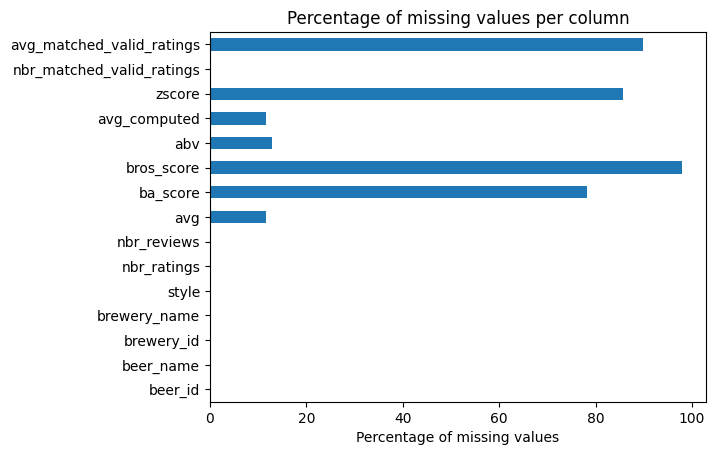

In [8]:
# show the percentage of missing values per columm
plt.figure()
(beers.isna().sum() / len(beers) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

**More comments about the dataset**

We see that more than 80% of the beers do not have a z-score value. We can drop this column alongside avg_computed and compute them manually later if needed.

80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

</blockquote>

In [9]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [10]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
93062,201311,36623,American Brown Ale,0,0,NaN,5.3
29717,201287,36118,American Pale Ale (APA),2,0,3.83,5.2
247989,232246,31272,American IPA,1,0,3.88,7.0


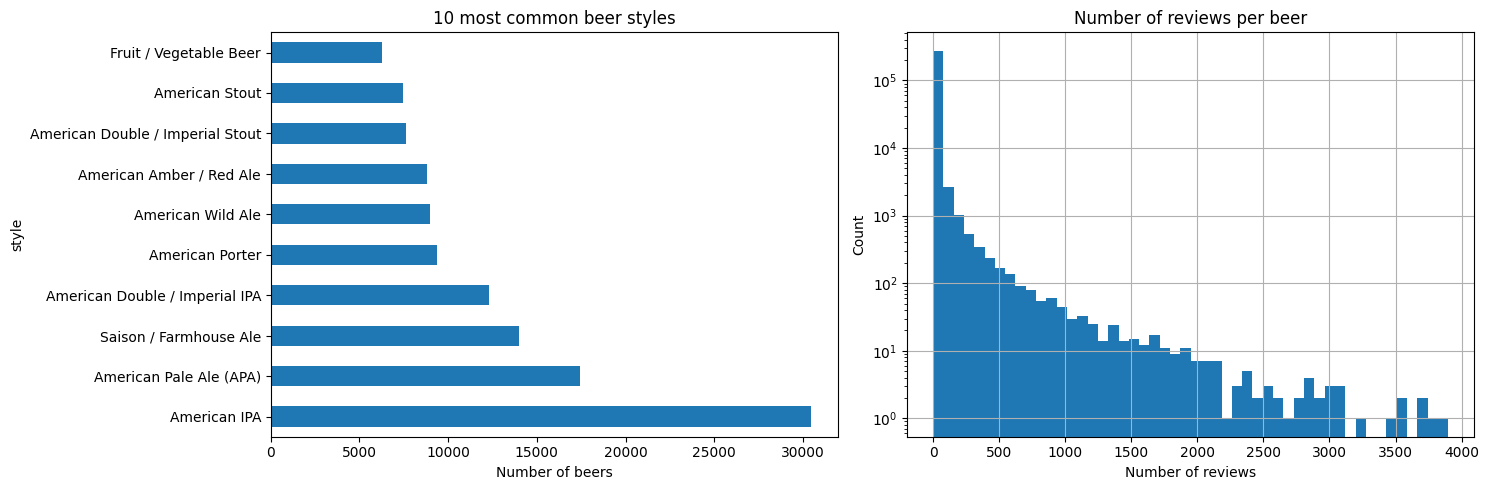

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

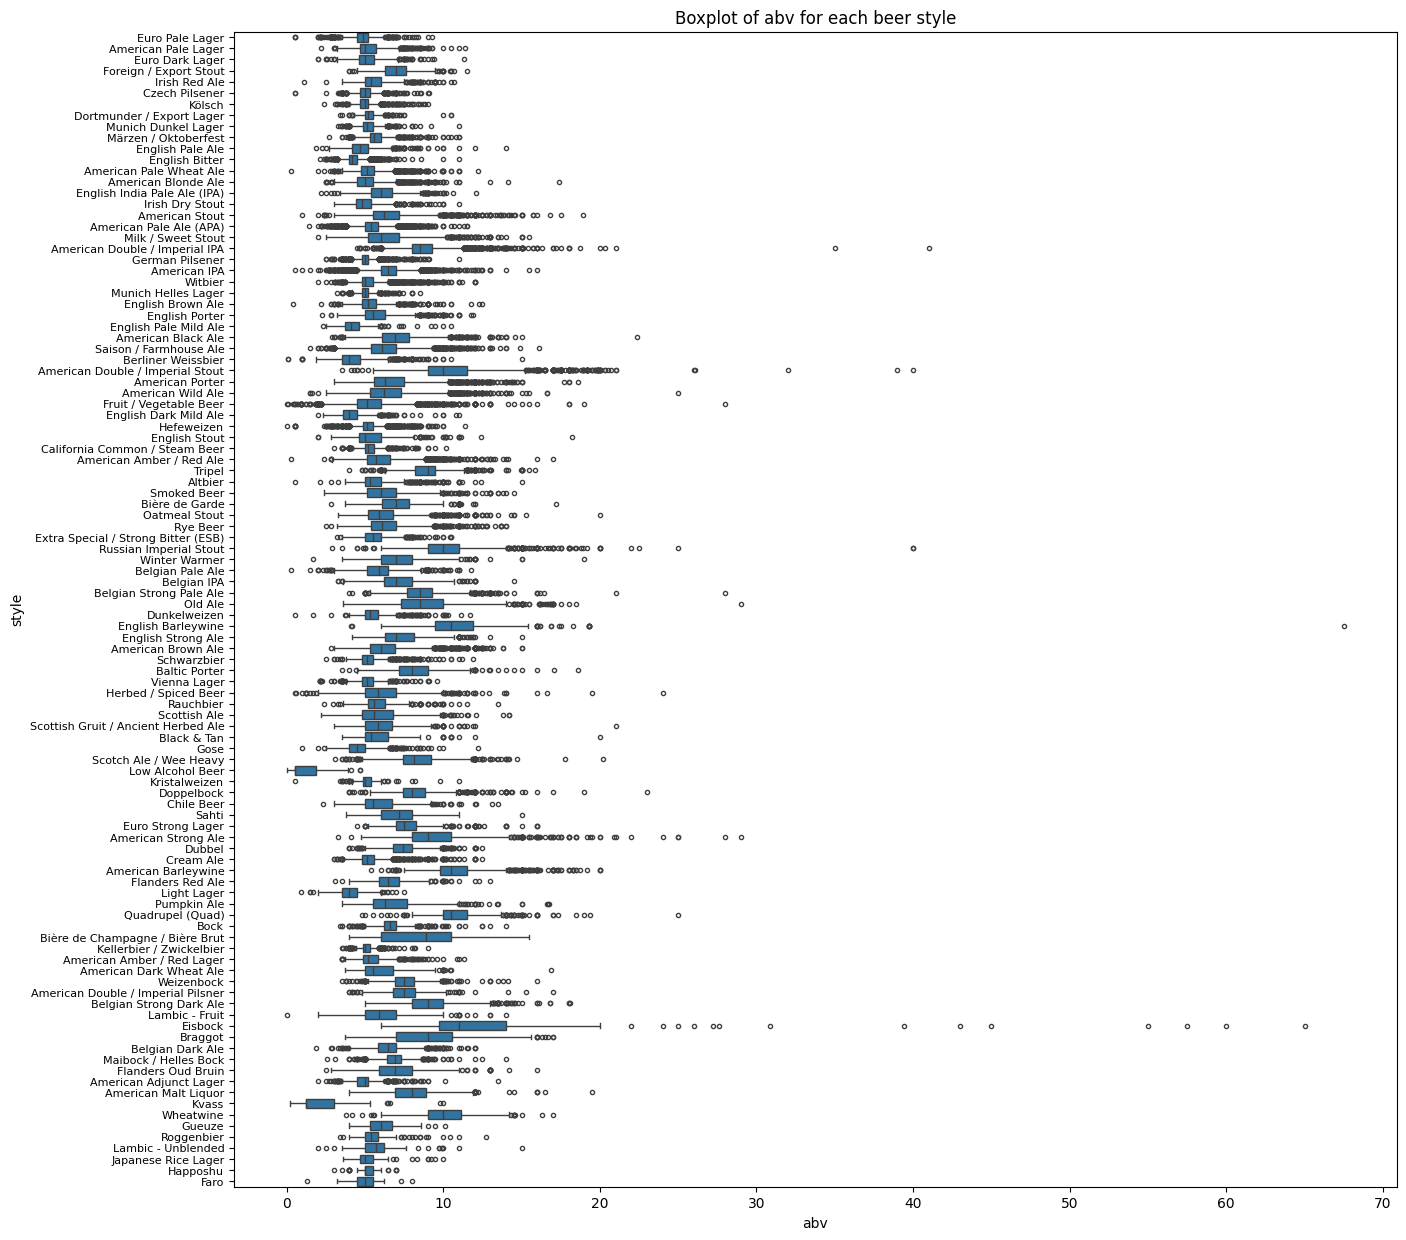

In [12]:
# show boxplot of abv for each beer style
plt.figure(figsize=(15, 15))
sns.boxplot(y='style', x='abv', data=beers_filtered, fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for each beer style')
plt.show()

In [13]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

style
American Blonde Ale    5.0
Low Alcohol Beer       0.5
Czech Pilsener         5.0
Name: abv, dtype: float64

In [14]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### Breweries dataset 🏭

In [15]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
13013,35874,"United States, Michigan",Brewery Becker,20
7376,36112,Latvia,ALEhouse,1
10160,907,"United States, Colorado",Dillon Dam Brewery,44


Shape of breweries :  (16758, 4)


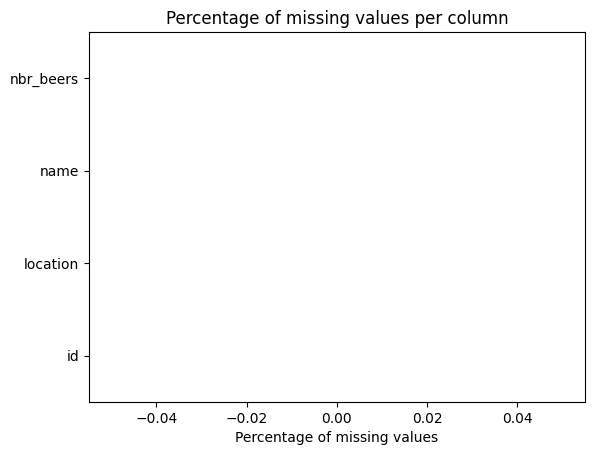

In [16]:
# show the percentage of missing values per columm
plt.figure()
(breweries.isna().sum() / len(breweries) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [17]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)
breweries_filtered = breweries.copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [18]:
breweries_filtered.sample(3)

,brewery_id,brewery_location,name,brewery_nbr_beers
13949,16389,"United States, Illinois",DESTIHL Restaurant & Brew Works,172
14146,25680,"United States, Illinois",Stanley Stawski Distributing,3
7105,45508,Netherlands,Gebrouwen Door Vrouwen,4


In [19]:
# Some breweries have weird location values, should find a way to clean them
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# should manully add the us state of the 35 breweries because it corresponds to to 15'319 reviews.

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [20]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()
strange_id

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'

In [21]:
# create a function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [22]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        # print('Brewery name:', breweries_filtered[breweries_filtered['brewery_id'] == key]['name'].values[0])
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [23]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [24]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [25]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


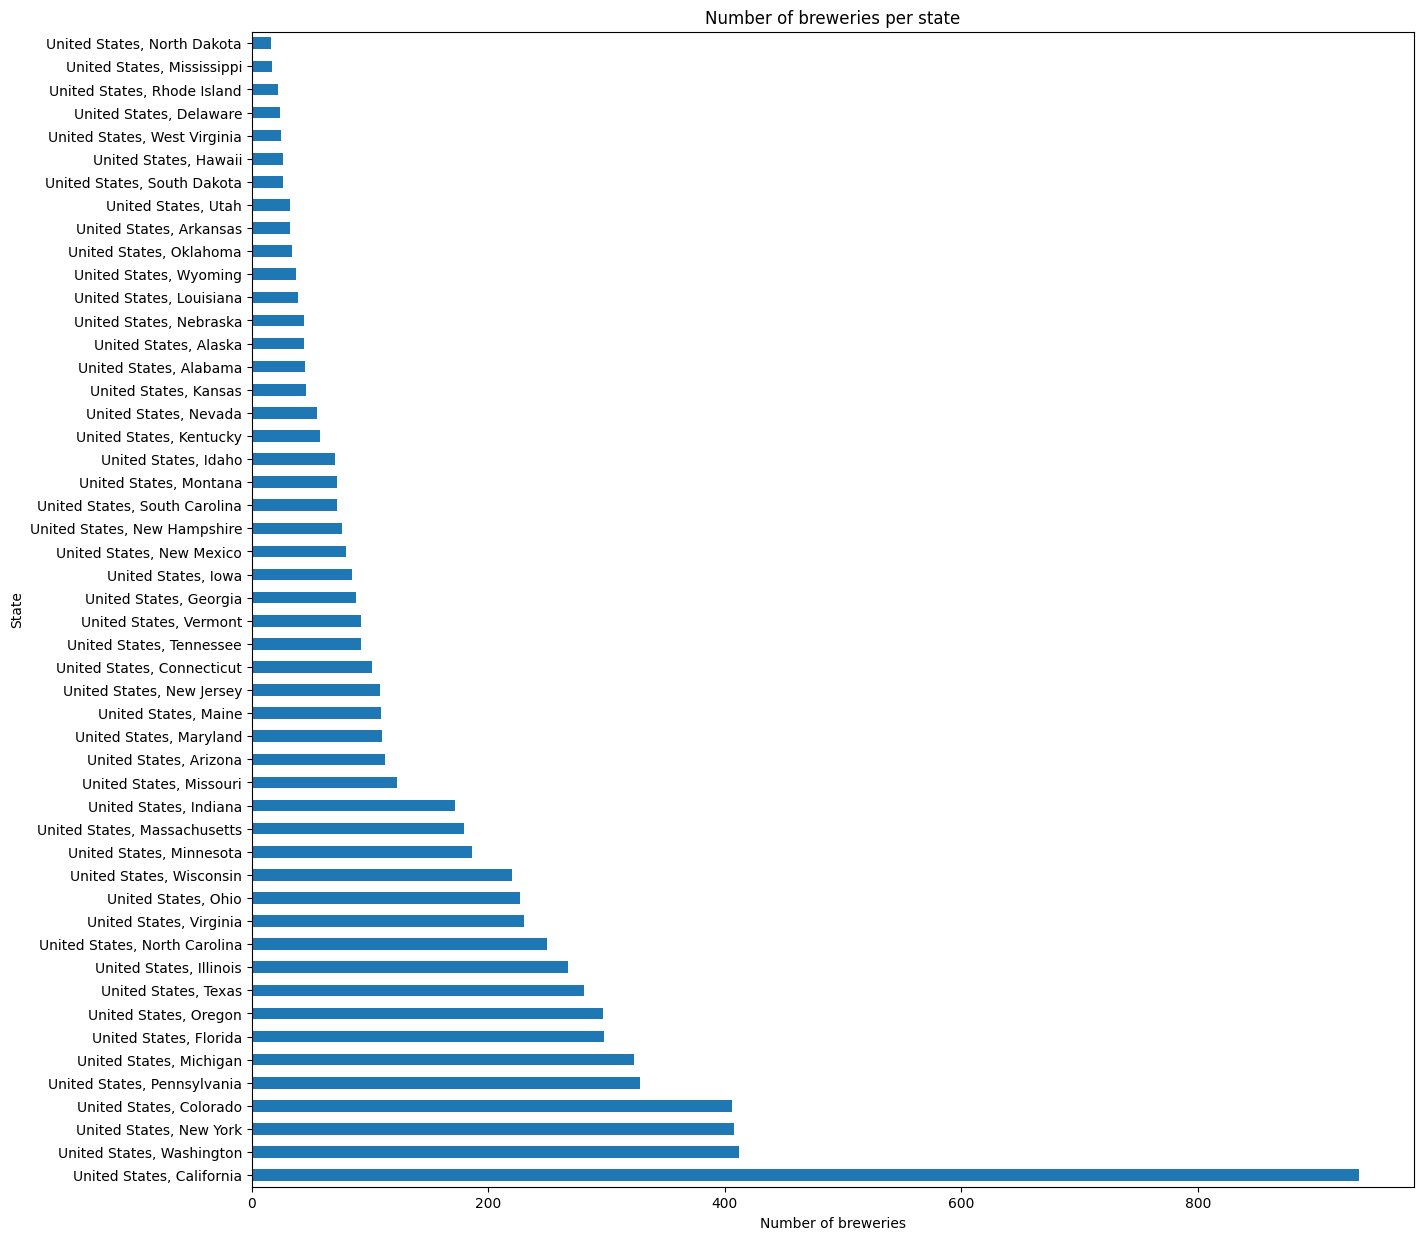

In [26]:
# plot the number of breweries per state as barh
plt.figure(figsize=(15, 15))
breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].value_counts().plot(kind='barh')
plt.title('Number of breweries per state')
plt.xlabel('Number of breweries')
plt.ylabel('State')
plt.show()

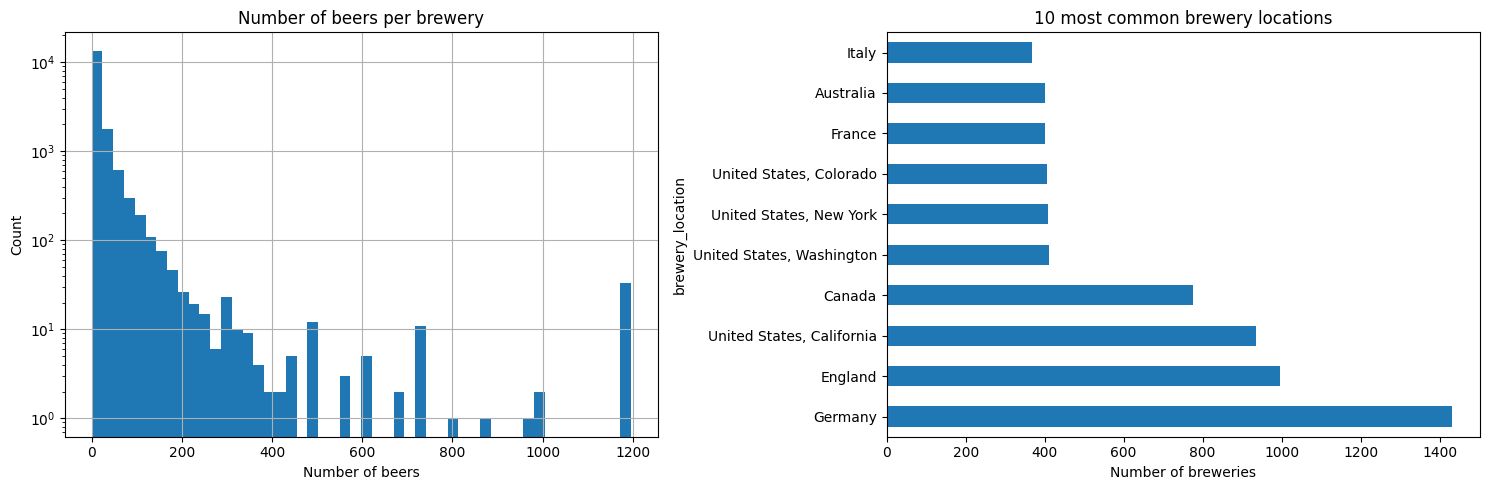

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### Users dataset 👤

In [28]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
75647,3,0,stephton.700287,Stephton,1.350986e+09,"United States, Texas"
137463,1,0,brewdoc.66125,brewdoc,1.140433e+09,"United States, New Hampshire"
133392,2,0,slthe2nd.846030,SLthe2nd,1.408097e+09,"United States, Massachusetts"


Shape of users :  (153704, 6)


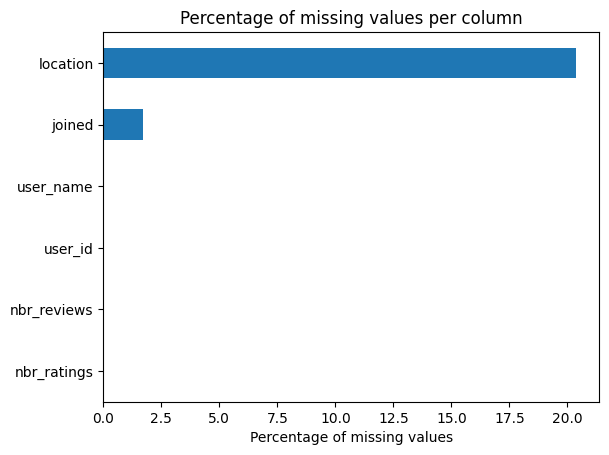

In [29]:
plt.figure()
(users.isna().sum() / len(users) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [30]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

users_filtered.sample(3)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
64449,2,2,jensvoigt.611912,1.311502e+09,"United States, Illinois"
93323,5,0,lukec.876487,1.413022e+09,NaN
62149,1,1,nesseight.1152681,1.465121e+09,"United States, Kansas"


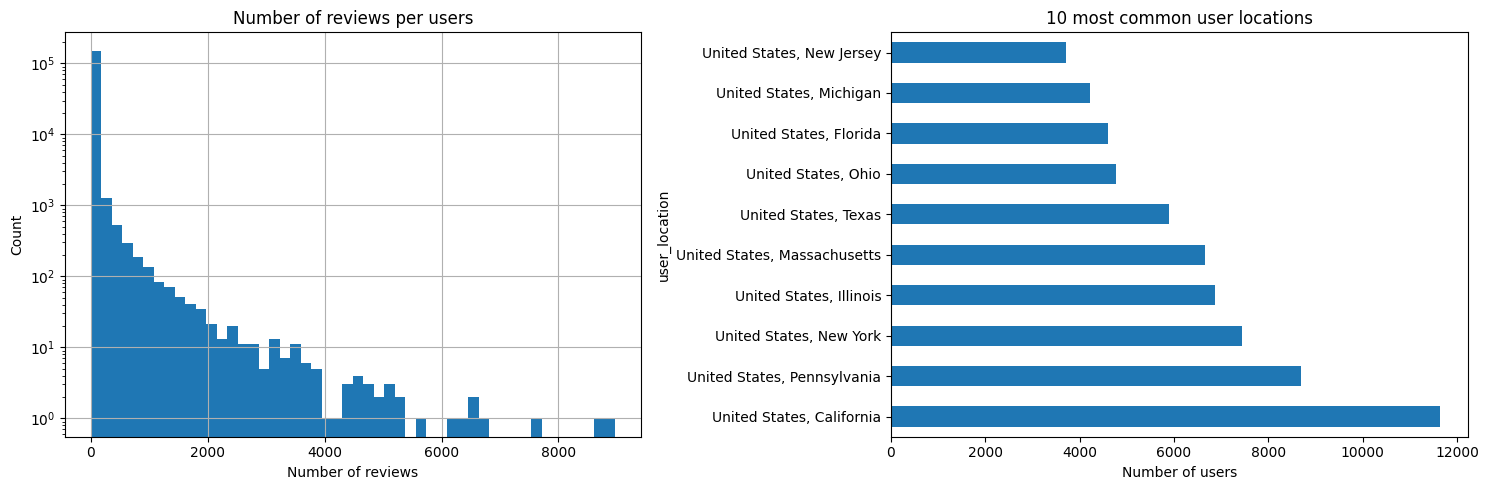

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### Reviews dataset 📝

In [32]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
842247,Belgo Anise Imperial Russian Stout,69363,Stone Brewing,147,Russian Imperial Stout,10.5,1309428000,colforbin73,colforbin73.443451,4.0,3.5,4.0,4.0,3.5,3.78,this is a VERY WELL MADE beer -- and when you ...
390854,Newcastle Founders' Ale,77775,Heineken Nederland B.V.,81,English Pale Ale,4.8,1328439600,NeroFiddled,nerofiddled.526,3.5,3.5,4.0,4.0,4.0,3.85,Newcastle Founders' AleThere are not a lot of ...
253179,Reissdorf Kölsch,2040,Brauerei Heinrich Reissdorf,288,Kölsch,4.8,1294830000,wcintula,wcintula.455097,4.0,4.0,3.5,3.5,4.0,3.75,Looks very nice poured in it's own Kölsch glas...


Shape of reviews :  (2589586, 16)


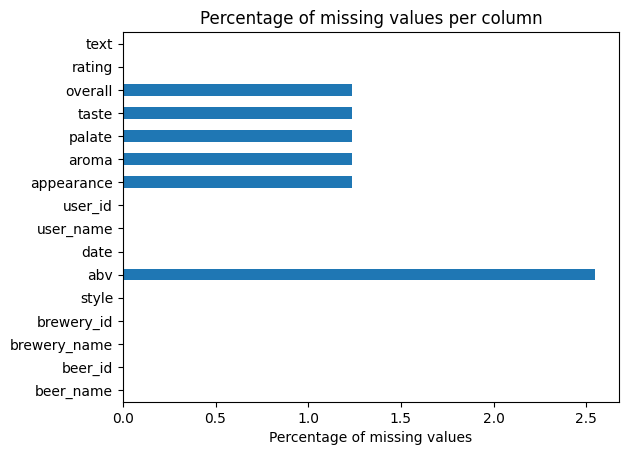

In [33]:
plt.figure()
(reviews.isna().sum() / len(reviews) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [34]:
# making sure that all the NaN are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009
all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [35]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
1424363,204,68,American Amber / Red Lager,1271325600,stigs.22284,3.5,3.0,3.5,3.0,3.0,3.08,"12oz bottle, served in a SA perfect pint glass..."
245784,759,72,Hefeweizen,1306317600,kirschy805.591518,4.5,5.0,4.0,4.5,4.5,4.57,Poured into a chilled hefeweizen glass. Head w...
2162433,20762,173,American Barleywine,1152784800,erdinger2003.39978,4.5,3.5,4.0,2.5,3.5,3.21,"The head is fluffy and thick, but falls away q..."


Shape of reviews_filtered :  (2557577, 12)


In [36]:
# count the number of NaN in columns ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews_filtered[reviews_filtered[col].isna()]))


Number of NaN values for each column :
overall : 0
taste : 0
palate : 0
aroma : 0
appearance : 0


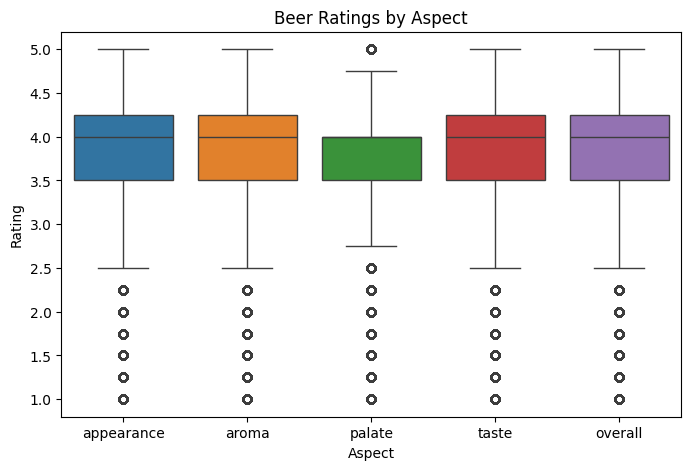

In [37]:
# show boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### Merge datasets 🔗

In [38]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,name,brewery_nbr_beers
1613887,77661,5476,American Pale Ale (APA),1327230000,mtnboy.99378,2.5,2.5,1.5,1.5,2.0,1.9,Appearance: Orange amber body. Not much to the...,1,1,1.9,5.4,954,954,1.158919e+09,Germany,"United States, Missouri",Bootleggers Restaurant & Brewery,8


Shape of df_merged :  (2557577, 23)


### Filter datasets ✂️

<div class="alert alert-block alert-danger">
<b>Danger:</b> Comment EVERY filtering
</div>

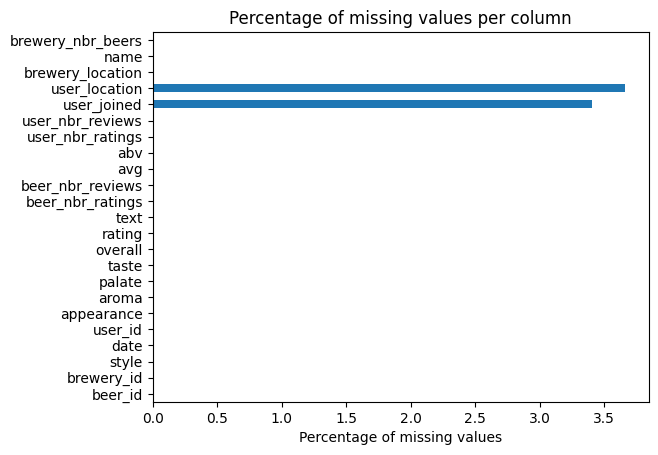

In [39]:
# show the percentage of missing values per columm
plt.figure()
(df_merged.isna().sum() / len(df_merged) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [40]:
# how many reviews have strange brewery location ?
print('Number of reviews with a weird location value:', len(df_merged[df_merged['brewery_location'].str.contains('<', na=False)]))

Number of reviews with a weird location value: 0


In [41]:
# how many reviews have no abv value ?
print('Number of reviews with no abv value:', len(df_merged[df_merged['abv'].isna()]))

Number of reviews with no abv value: 0


In [42]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

In [43]:
# What is the percentage of reviews with at least one NaN value ?
print('Percentage of reviews with at least one NaN value :', len(df_merged[df_merged.isna().any(axis=1)]) / len(df_merged) * 100)
print('This corresponds to', len(df_merged[df_merged.isna().any(axis=1)]), 'reviews')

Percentage of reviews with at least one NaN value : 3.662450827482418
This corresponds to 93670 reviews


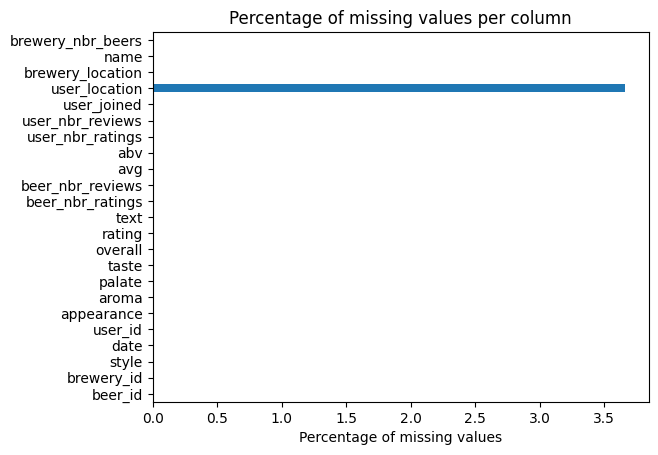

In [44]:
# show the percentage of missing values per columm
plt.figure()
(df_merged.isna().sum() / len(df_merged) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [45]:
# Save to csv
df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

## Data enrichment 🍺

In [3]:
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [4]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
418679,927,358,Irish Dry Stout,4.1,1164538800,blackhaddock.90923,4.00,3.00,3.5,3.5,3.5,3.41,"Drank in the British Legion Club, Dawley.Cold ...",785,552,3.80,3050,3050,1.154686e+09,England,Ireland,3
1341468,17060,158,American Double / Imperial IPA,10.0,1146304800,far333.1030,4.50,5.00,4.0,4.5,4.5,4.57,"Golden apricot colored, a bit hazed, with a th...",4168,1583,4.13,1272,1271,1.037444e+09,"United States, Connecticut","United States, Colorado",148
356540,111400,10823,German Pilsener,4.8,1394967600,dcmchew.760280,3.25,3.75,3.5,3.5,3.5,3.55,A few days past the &quot;best before&quot; da...,3,1,3.54,4868,779,1.382436e+09,Romania,Austria,7


Shape of df :  (2557577, 22)


### Serving type (naive approach) 🍾🥤🚰

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served. 
For now, we use a naive approach. We only look at whether a word specific to as service style has been used. 

In [5]:
# Create 3 different columns according to the text review, "bottle", "can", "draft"

bottle = ['bottle', 'bottled', 'bottles']
can = [' can ', 'canned', ' cans ']
draft = ['draft', 'draught', 'tap', 'taps']
# Create different columns if review text contains the word
df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))

In [6]:
# remove every row where columns bottle, can and draft are all False
df = df[df[['bottle', 'can', 'draft']].any(axis=1)]
# display(df.sample(3))
# print('We have {} valid reviews'.format(df.shape[0]))

# remove every row with more than 1 true
df = df[df[['bottle', 'can', 'draft']].sum(axis=1) == 1]
# display(df.sample(3))
# print('We have {} valid reviews'.format(df.shape[0]))

#create a new column with the serving type
df['serving_type'] = df[['bottle', 'can', 'draft']].idxmax(axis=1)

# drop the columns bottle, can and draft
df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)

display(df.sample(3))

# print the number of reviews for each serving type
df['serving_type'].value_counts(normalize=False)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type
843477,62254,147,Belgian Strong Pale Ale,9.5,1297249200,johnqvegas.196314,3.5,4.00,4.5,4.5,4.50,4.32,"Bottle into The Bruery tulip, refrigerated sin...",957,476,3.75,833,833,1.203332e+09,"United States, Tennessee","United States, California",671,bottle
107357,25117,9056,Witbier,5.0,1314180000,swampski.210292,3.5,3.50,3.0,3.0,3.00,3.15,I had an earlier review of this beer - from an...,21,8,3.36,13,13,1.207735e+09,"United States, Louisiana",Ukraine,9,bottle
1931657,1932,139,Pumpkin Ale,4.7,1383390000,youngs11.739319,3.0,3.25,3.0,2.5,2.75,2.81,Poured from bottle into pint glass.Light golde...,2675,880,2.89,48,46,1.372586e+09,"United States, Massachusetts","United States, Maine",94,bottle


serving_type
bottle    653386
can       199071
draft     184124
Name: count, dtype: int64

### Sentiment analysis 📝

In [7]:
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
# Load positive and negative word lists
with open("data/positive.txt", "r") as f:
    positive_words = f.read().splitlines()

with open("data/negative.txt", "r") as f:
    negative_words = f.read().splitlines()
    
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [9]:
text = df.sample(1)['text'].values[0].lower()
print(text)

### textblob
print('Polarity textblob:',TextBlob(text).sentiment.polarity)
# print('Subjectivity:',TextBlob(text).sentiment.subjectivity)

### TF-IDF
# Fit and transform the review text
tfidf_matrix = vectorizer.fit_transform([text])

# Calculate the cosine similarity between the review and positive/negative word vectors
positive_vector = vectorizer.transform([" ".join(positive_words)])
negative_vector = vectorizer.transform([" ".join(negative_words)])

cosine_sim_pos = cosine_similarity(tfidf_matrix, positive_vector)
cosine_sim_neg = cosine_similarity(tfidf_matrix, negative_vector)

# Calculate the polarity score
polarity_score = cosine_sim_pos - cosine_sim_neg

print("Polarity tf-idf:", polarity_score[0][0])

served on tap on 5-10-10 at kraftwork.pours pitch black and completely opaque with a two finger head with decent retention, slowly fading into a lasting cap and ring. minimal spots of lacing.sweet roasted malt aroma with lots of burnt toast, chocolate malt, molasses, brown sugar and espresso/coffee bean. possibly some licorice. earthy hops provide a nice balance of bitterness to the roasted and sweet notes.lighter bodied than expected with a lot of dark roasted malts up front with hints of chocolate, burnt toast, coffee and oatmeal. decently balanced by a sweet chocolate and molasses/honey flavor and some nice bitter, dry hops. very dry finish. complex but thinner than i expected or would have liked. well balanced and drinkable.
Polarity textblob: 0.07316666666666666
Polarity tf-idf: 0.1463960800741939


## Data filtering 🧹
Number of valid reviews per beer and users & average rating per beer

### Filtering on amount of reviews

In [10]:
# compute the number of valid reviews per user
df['user_nbr_reviews_computed'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_nbr_reviews_computed'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_avg_computed'] = df.groupby('beer_id')['rating'].transform('mean')

df.sample(3)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed
1480786,13450,450,English Strong Ale,8.0,1294311600,babysnakes.517983,4.50,4.50,4.00,4.50,4.00,4.35,Bottle into pint glassI find the honey-orange ...,865,297,3.78,22,21,1.287914e+09,"United States, Pennsylvania","United States, Pennsylvania",120,bottle,4,129,3.746667
869051,167623,147,American Brown Ale,9.0,1431770400,bone53.781529,4.25,3.75,4.00,3.75,4.00,3.86,On tap @ Blue DustThis is a drinkable high abv...,494,127,3.90,317,307,1.392116e+09,"United States, Pennsylvania","United States, California",671,draft,124,51,3.900980
1612749,82803,27870,American Pale Wheat Ale,5.0,1388401200,huskyinpdx.557154,4.00,3.50,3.75,3.75,3.75,3.71,Bottle opened on 12.11.13A - Pours a hazy ligh...,499,64,3.80,2408,1762,1.295780e+09,"United States, Washington","United States, Missouri",144,bottle,1539,24,3.871250


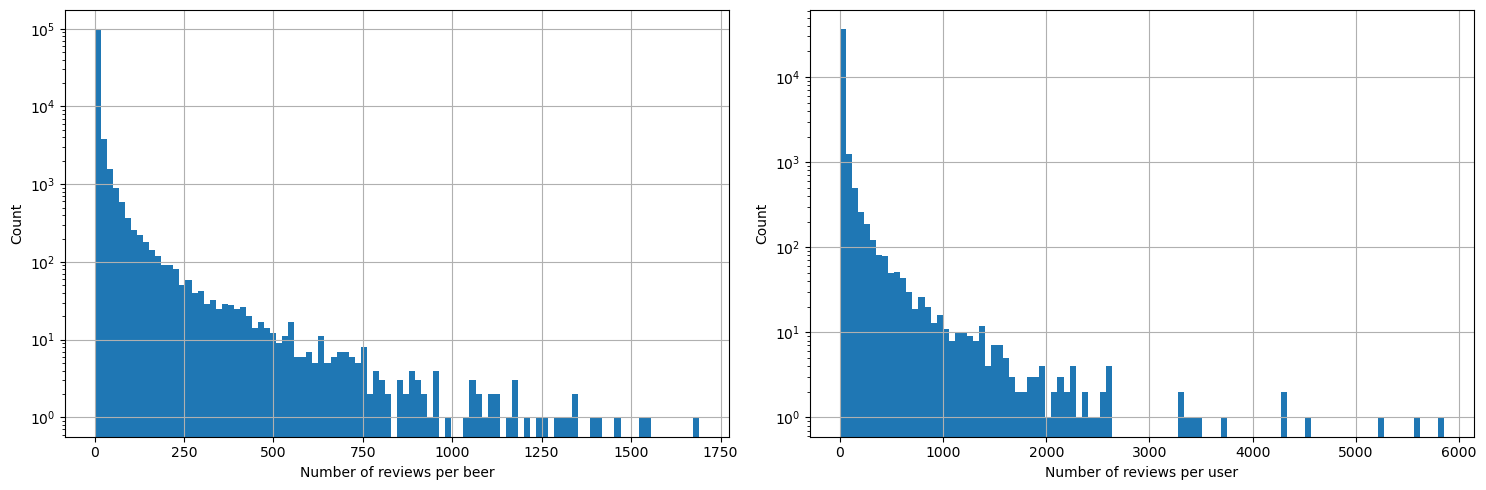

In [11]:
plt.figure(figsize=(15, 5))

# group the reviews by beer_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 1)
df.groupby('beer_id')['beer_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per beer')
plt.ylabel('Count')

# group the reviews by user_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 2)
df.groupby('user_id')['user_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
#Filtering to remove users and beers with less reviews

min_nbr_reviews_per_user = 0
min_nbr_reviews_per_beer = 20

len0 = df.shape[0]

# remove every row where the number of reviews per user is less than min_nbr_reviews_per_user
df_filter = df[df['user_nbr_reviews_computed'] >= min_nbr_reviews_per_user].copy(deep=True)

# remove every row where the number of reviews per beer is less than min_nbr_reviews_per_beer
df_filter_full = df_filter[df_filter['beer_nbr_reviews_computed'] >= min_nbr_reviews_per_beer].copy(deep=True)

print('We removed {} rows, leaving us with {} %% of the original dataset'.format(len0 - df_filter_full.shape[0], round(df_filter_full.shape[0] / len0 * 100, 2)))
print('We have {} valid reviews'.format(df_filter_full.shape[0]))

# print the number of reviews for each serving type
df_filter_full['serving_type'].value_counts(normalize=False)

We removed 283282 rows, leaving us with 72.67 %% of the original dataset
We have 753299 valid reviews


serving_type
bottle    514624
can       148085
draft      90590
Name: count, dtype: int64

### Filter on readability score of the reviews 📝

In [13]:
df_sample = df_filter_full.sample(n=1000, random_state=46)

<Axes: >

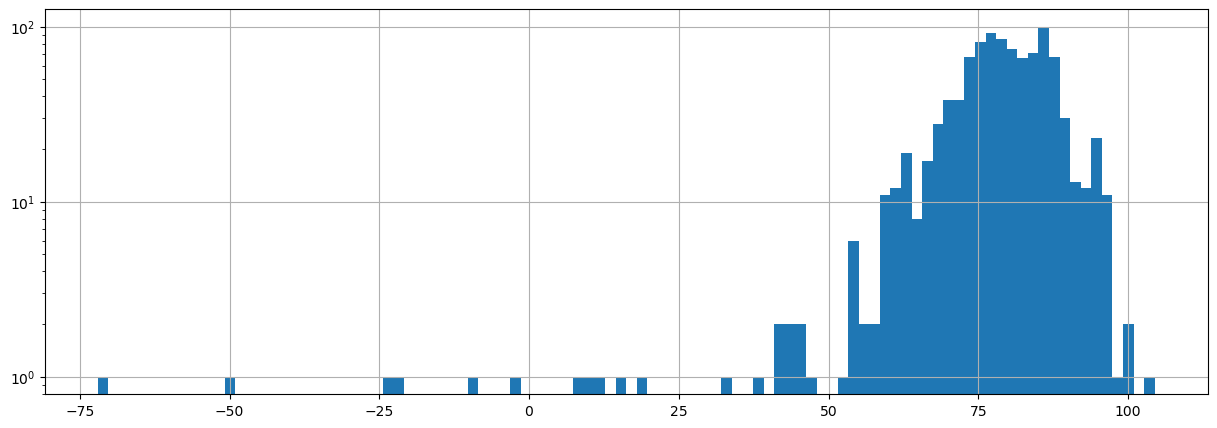

In [14]:
df_sample['readability_score'] = df_sample['text'].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) else None)
df_sample['readability_score'].hist(bins=100, figsize=(15, 5), log=True)

In [15]:
# printing some reviews based on readability score

df_sample[df_sample['readability_score'] < 20]['text'].count()

# for row in df_sample[df_sample['readability_score'] > 96]['text']:
#     print(row)
#     print('----------------------')

11

In [16]:
# remove reviews with bad readability score



### Extracting the serving mode with NLP

In [17]:
import nltk
import spacy
from nltk import word_tokenize, pos_tag, ne_chunk
nlp = spacy.load("en_core_web_sm")

In [28]:
df_nlp = df_filter_full.sample(n=1000, random_state=46).copy(deep=True)

In [30]:
def differentiate_can(sentence):
    doc = nlp(sentence)
    verbes_nom=[]
    for token in doc:
        if token.text.lower() == "can":
            if any(t.dep_ == "aux" for t in token.head.children):
                verbes_nom .append("verb")
            else:
                verbes_nom .append("noun") 
    
    return verbes_nom

In [31]:
ex_review_1 = str("Can I go to the bathroom I had a beer in a can even if I would have prefered it served by draft because I can")
ex_review_2 = str("Plase can you stop eating from the can")
print(differentiate_can(ex_review_1))
print(differentiate_can(ex_review_2))

['verb', 'noun', 'verb']
['verb', 'noun']


In [ ]:
# use differentiate_can to filter reviews 
df_nlp['can'] = df_nlp['text'].apply(lambda x: differentiate_can(x) if isinstance(x, str) else None)

In [23]:
def extract_serving_style(text):
    # Process the text using spaCy
    doc = nlp(text)
    
    # Initialize the serving style variable
    serving_style = None
    
    # Analyze the dependency tree and part-of-speech tags
    # Find the serving styles
    for token in doc:
        if "can" == token.lemma and token.dep_ == "nsubj":
            serving_style = "can"
            break
        elif "bottle" == token.lemma and token.dep_ == "nsubj" and "VB" in token.head.pos_:
            serving_style = "bottle"
            break
        elif "tap" == token.lemma and token.dep_ == "nsubj" and "VB" in token.head.pos_:
            serving_style = "tap"
            break
    
    return serving_style

In [24]:
ex_review = str("Can. I would love to try it on tap")

In [25]:
doc = nlp(ex_review)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

Can can AUX ROOT
. . PUNCT punct
I I PRON nsubj
would would AUX aux
love love VERB ROOT
to to PART aux
try try VERB xcomp
it it PRON dobj
on on ADP prep
tap tap NOUN pobj


In [26]:
print(extract_serving_style(ex_review))

None


In [27]:
df_nlp['text'].sample(1)

NameError: name 'df_nlp' is not defined

In [ ]:
%%time
df_nlp['serving_style'] = df_test_nlp['text'].apply(extract_serving_style)

In [ ]:
# Look if all serving_style values are still None (True or False)
df_nlp['serving_style'].isna().all()

### Countries grouping 🌍

In [ ]:
countries = pd.read_csv('data/countries.csv', usecols=['name', 'region', 'sub-region'])
countries.sample(1)

### Visualization 📊

In [ ]:
# print some reviews for each serving type
print('Reviews with bottle:\n')
for text in df[df['serving_type'] == 'bottle']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with can:\n')
for text in df[df['serving_type'] == 'can']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with draft:\n')
for text in df[df['serving_type'] == 'draft']['text'].sample(1):
    print(text)
    print('----------------------')

In [ ]:
# print the average value of the rating for each serving type
comp_str = 'rating'
print('Average ' + comp_str + ' for bottle: ', round(df[df['serving_type'] == 'bottle'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for can: ', round(df[df['serving_type'] == 'can'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for draft: ', round(df[df['serving_type'] == 'draft'][comp_str].mean(), 3))

In [ ]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type', y='rating')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

# Statistical Analysis 📈

### Measure the impact of each aspect on rating 📏

In [ ]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### Hypothesis testing on the new labels

In [ ]:
def do_ttest(type1, type2, category):
    ttest = ttest_ind(df[df['serving_type'] == type1][category],df[df['serving_type'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

In [ ]:
# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type'] == 'bottle'][columns[i]], df[df['serving_type'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type'] == 'can'][columns[i]], df[df['serving_type'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type'] == 'draft'][columns[i]], df[df['serving_type'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
# ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

All the p-values are below 0.05 (expect 1), so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

In [ ]:
# t-test for aroma betwwen draft and bottle
do_ttest('draft', 'bottle', 'aroma')

In [ ]:
# show a boxplot of aroma for draft and bottle
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['serving_type'].isin(['draft', 'bottle'])], x='serving_type', y='aroma')
plt.show()